<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Modelling

During this phase, we will discuss about possibles models to predict discharge given a temperature and past history of a particular river location according to the result of the Granger Causality.

## Choice of the Model

According to the Data Analysis assumption, we will define some prediction models related to the correlation with temperatures and precipitations where these variables have causal dependant on the river location of our interest. In other words, we can predict the future discharge values of a given point using different approaches based on the impact of temperatures and precipitation variations on the river flow. In this notebook, we will analyze different algorithms and choose the best one for both approaches specified at the end of the data analysis notebook. In detail, we can test the prediction efficiency using RMSE evaluation on the testing set (composed of samples on the 2021-2022 periods). During the application usage, models will be trained on the complete dataset to improve the future prediction of the period above 2022.


## Libraries dependencies

In [1]:
%pip install seaborn
%pip instal matplotlib
%pip install sklearn
%pip install pandas
%pip install pmdarima
#!pip install seaborn

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "instal" - maybe you meant "install"
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime, json
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.dates as mdates
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore') 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
j = 6
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
for i in range(2011, 2023):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [4]:
# print the head of dataset.
data = df
df.head()

,time,lat,lon,discharge,temp,prec
0,2011-01-01 12:00:00,44.750378,7.56052,11.211914,5.205774,0.0
1,2011-01-02 12:00:00,44.750378,7.56052,10.950195,4.364069,0.000006
2,2011-01-03 12:00:00,44.750378,7.56052,10.685547,6.473016,0.000002
3,2011-01-04 12:00:00,44.750378,7.56052,10.419922,8.097437,0.0
4,2011-01-05 12:00:00,44.750378,7.56052,10.15918,6.304498,0.0


In [ ]:
df.describe()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36972957 entries, 0 to 1184630
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   time       object
 1   lat        object
 2   lon        object
 3   discharge  object
 4   temp       object
 5   prec       object
dtypes: object(6)
memory usage: 1.9+ GB


## Preprocessing Data

In [6]:
# defines coordinates of filtering and group by their locations.
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

In [7]:
# set the coordinates as index of the dataframe
df_drop = df.drop(columns = ['time', 'discharge', 'temp', 'prec'], inplace=False)
df['coords'] = df_drop.apply(tuple, axis=1)
df = df.set_index(['coords', 'time'])
df.tail()

lat        lon discharge  \
coords                time                                                 
(41.23425, 13.701608) 2022-05-09 12:00:00  41.23425  13.701608  0.193359   
                      2022-05-10 12:00:00  41.23425  13.701608  0.158203   
                      2022-05-11 12:00:00  41.23425  13.701608  0.144043   
                      2022-05-12 12:00:00  41.23425  13.701608  0.137695   
                      2022-05-13 12:00:00  41.23425  13.701608  0.133789   

                                                temp      prec  
coords                time                                      
(41.23425, 13.701608) 2022-05-09 12:00:00   16.09704  0.000024  
                      2022-05-10 12:00:00   16.31582  0.000002  
                      2022-05-11 12:00:00  18.108545       0.0  
                      2022-05-12 12:00:00    18.9703       0.0  
                      2022-05-13 12:00:00  19.163446       0.0

In [8]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points_new_fill.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

print(coords['features'][:2])


[{'type': 'Feature', 'name': 'Fiume Po', 'id': 0, 'geometry': {'type': 'Point', 'coordinates': [7.6197023, 44.841927]}}, {'type': 'Feature', 'name': 'Po', 'id': 1, 'geometry': {'type': 'Point', 'coordinates': [7.673447, 45.068577]}}]


In [9]:
coords_tuple = []
for i in range(len(lats)):
    coords_tuple.append(tuple([lats[i], longs[i]]))

rivers = pd.DataFrame()
rivers = data[data['coords'].isin(coords_tuple)]
rivers.head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


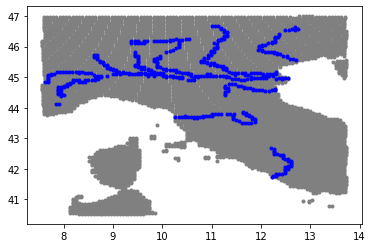

In [8]:
coords_rivers = rivers.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
coords_rivers = coords_rivers.aggregate(aggregation_functions)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

In [10]:
datasource = json.load(open('../samples/source_mounth.json', 'r'))
sources_rivers = []
names = []
mounths_rivers = []
italy_sources_mounths = pd.DataFrame()
for key in datasource.keys():
    sources_rivers.append(datasource[key]['source'])
    mounths_rivers.append(datasource[key]['mounth'])
    names.append(key)

italy_sources_mounths['names'] = names
italy_sources_mounths['mounth'] = mounths_rivers
italy_sources_mounths['source'] = sources_rivers
italy_sources_mounths['number_value'] = [i for i in range(0, len(italy_sources_mounths))]
italy_sources_mounths.head()

,names,mounth,source,number_value
0,Tanaro,"[44.950962, 8.690675]","[44.12503, 7.8367176]",0
1,Po,"[44.974716, 12.487255]","[44.841927, 7.6197023]",1
2,Tevere,"[41.730213, 12.233403]","[42.679653, 12.207837]",2
3,Arno,"[43.69623, 10.266045]","[43.864105, 11.632074]",3
4,Reno,"[44.61863, 12.282794]","[44.410408, 11.271765]",4


In [11]:
sources = {}
mounths = {}
names = list(italy_sources_mounths.names)
print("Time series on the following rivers: {}".format(names))
for i in range(len(italy_sources_mounths)):
    name = names[i]
    sources[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['source'][i])]
    mounths[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['mounth'][i])]

Time series on the following rivers: ['Tanaro', 'Po', 'Tevere ', 'Arno', 'Reno', 'Ticino', 'Adda', 'Oglio', 'Adige', 'Piave']


In [14]:
sources['Po'].head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


In [12]:
sources2 = {}
mounths2 = {}
for name in names:
    df = sources[name].copy(deep=True)
    df2 = mounths[name].copy(deep=True)
    df.index = sources[name]['time']
    df2.index = mounths[name]['time']
    df.drop(columns=['time'], inplace=True)
    df2.drop(columns=['time'], inplace=True)
    sources2[name] = df.copy(deep=True)
    mounths2[name] = df2.copy(deep=True)
print(sources['Po'].head())
print('-'*40)
print(mounths['Po'].head())


                      time        lat       lon  discharge      temp  \
18980  2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165   
18981  2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876   
18982  2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906   
18983  2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682   
18984  2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247   

           prec                  coords  
18980       0.0  (44.841927, 7.6197023)  
18981  0.000002  (44.841927, 7.6197023)  
18982  0.000001  (44.841927, 7.6197023)  
18983       0.0  (44.841927, 7.6197023)  
18984       0.0  (44.841927, 7.6197023)  
----------------------------------------
                        time        lat        lon  discharge      temp  \
2570330  2011-01-01 12:00:00  44.974716  12.487255  1926.4092  7.344354   
2570331  2011-01-02 12:00:00  44.974716  12.487255  1750.8271   7.95199   
2570332  2011-01-03 12:00:00  44.974716  12.48725

## Starting Modelling Phase

Text(0, 0.5, 'Discharge (m^3/s)')

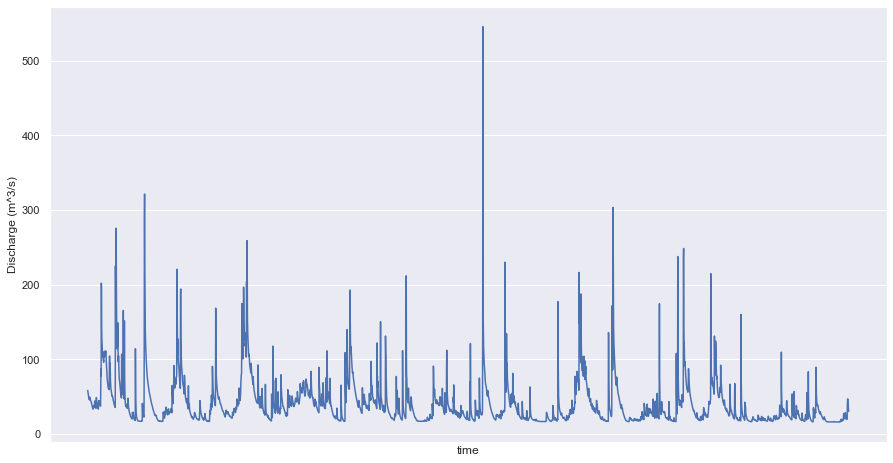

In [16]:
sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='time', y='discharge', data=sources2['Po'], markers='')
ax.set_xticks([])
ax.set_ylabel('Discharge (m^3/s)')

Text(0, 0.5, 'Discharge (m^3/s)')

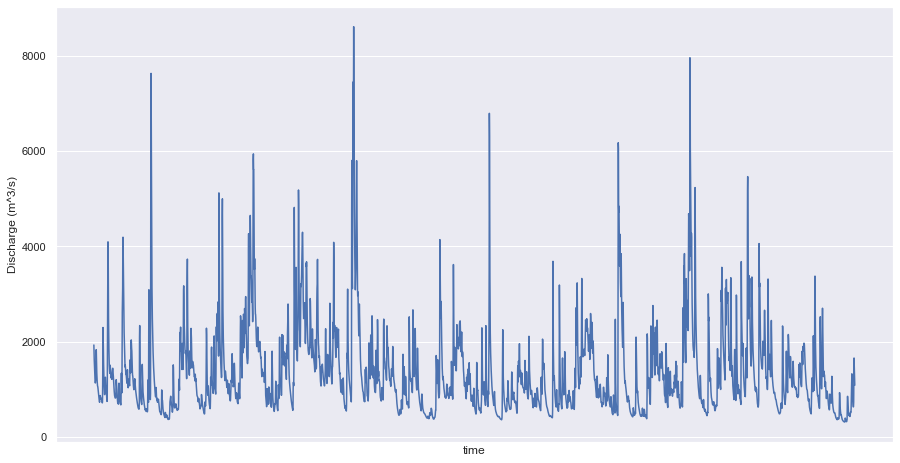

In [17]:

sns.set(rc={'figure.figsize':(15, 8)})
ax = sns.lineplot(x='time', y='discharge', data=mounths2['Po'], markers='')
ax.set_xticks([])
ax.set_ylabel('Discharge (m^3/s)')

According to the analysis observations, the month of discharge is exponentially more significant than the values of the source. So, we need to verify if the prediction on sources which low variability has the similar performances to the month forecasting

### Data Splitting

In [13]:
sources['Po'].head()

,time,lat,lon,discharge,temp,prec,coords
18980,2011-01-01 12:00:00,44.841927,7.619702,58.29492,5.29165,0.0,"(44.841927, 7.6197023)"
18981,2011-01-02 12:00:00,44.841927,7.619702,56.325195,4.353876,0.000002,"(44.841927, 7.6197023)"
18982,2011-01-03 12:00:00,44.841927,7.619702,54.467773,5.771906,0.000001,"(44.841927, 7.6197023)"
18983,2011-01-04 12:00:00,44.841927,7.619702,52.753906,8.080682,0.0,"(44.841927, 7.6197023)"
18984,2011-01-05 12:00:00,44.841927,7.619702,51.195312,6.497247,0.0,"(44.841927, 7.6197023)"


In [13]:
train = {}
test = {}
keys = sources.keys()
for key in keys:
    train[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    test[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    train[key]['source'] = sources[key][:int(0.7*(len(sources[key])))]
    test[key]['source'] =  sources[key][int(0.7*(len(sources[key]))):]
    train[key]['mounth'] = mounths[key][:int(0.7*(len(mounths[key])))]
    test[key]['mounth'] = mounths[key][int(0.7*(len(mounths[key]))):]


In [20]:
train['Po']['source'].tail()

,time,lat,lon,discharge,temp,prec,coords
19060,2020-01-29 12:00:00,44.841927,7.619702,24.327148,5.885065,0.0,"(44.841927, 7.6197023)"
19061,2020-01-30 12:00:00,44.841927,7.619702,23.749023,4.60296,0.0,"(44.841927, 7.6197023)"
19062,2020-01-31 12:00:00,44.841927,7.619702,23.136719,7.926874,0.0,"(44.841927, 7.6197023)"
19063,2020-02-01 12:00:00,44.841927,7.619702,22.53247,11.847681,0.0,"(44.841927, 7.6197023)"
19064,2020-02-02 12:00:00,44.841927,7.619702,22.000488,9.017358,0.0,"(44.841927, 7.6197023)"


In [21]:
test['Po']['source'].head()

,time,lat,lon,discharge,temp,prec,coords
19065,2020-02-03 12:00:00,44.841927,7.619702,21.515625,8.64306,0.0,"(44.841927, 7.6197023)"
19066,2020-02-04 12:00:00,44.841927,7.619702,23.761719,9.213586,0.0,"(44.841927, 7.6197023)"
19067,2020-02-05 12:00:00,44.841927,7.619702,28.403809,7.982568,0.0,"(44.841927, 7.6197023)"
19068,2020-02-06 12:00:00,44.841927,7.619702,25.848633,9.044794,0.0,"(44.841927, 7.6197023)"
19069,2020-02-07 12:00:00,44.841927,7.619702,23.666992,9.13653,0.0,"(44.841927, 7.6197023)"


In [14]:
for key in keys:
    train[key]['source'] = train[key]['source'].drop(columns=['lat', 'lon', 'coords'])
    train[key]['mounth'] = train[key]['mounth'].drop(columns=['lat', 'lon', 'coords'])
    test[key]['source'] = test[key]['source'].drop(columns=['lat', 'lon', 'coords'])
    test[key]['mounth'] = test[key]['mounth'].drop(columns=['lat', 'lon', 'coords'])

In [23]:
train['Po']['source'].head()

,time,discharge,temp,prec
18980,2011-01-01 12:00:00,58.29492,5.29165,0.0
18981,2011-01-02 12:00:00,56.325195,4.353876,0.000002
18982,2011-01-03 12:00:00,54.467773,5.771906,0.000001
18983,2011-01-04 12:00:00,52.753906,8.080682,0.0
18984,2011-01-05 12:00:00,51.195312,6.497247,0.0


In [ ]:
train_x =  train['Po']['source']
train_x.index = train_x.time
train_x = train_x.drop(columns=['time', 'temp', 'prec'])

test_x = test['Po']['source']
test_x.index = test_x.time
test_x = test_x.drop(columns=['time', 'temp', 'prec'])

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='.')
plt.plot(train_x, label='Train', **kws)
plt.plot(test_x, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1])

## SARIMA Modelling

In [25]:
# prepare a copy of data for SARIMA 
sarima_train = {}
sarima_test = {}

for key in keys:
    # define key
    sarima_train[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    sarima_test[key] = {'source' : pd.DataFrame(), 'mounth' : pd.DataFrame()}
    # copy from the original dataset
    for x in ['source', 'mounth']:
        sarima_train[key][x] = train[key][x].copy(deep=True)
        sarima_test[key][x] = test[key][x].copy(deep=True)
        # setup info in the correct format type)
        sarima_train[key][x]['discharge'] = sarima_train[key][x]['discharge'].astype(float)
        sarima_train[key][x]['time'] = pd.to_datetime(sarima_train[key][x]['time'], format = '%Y-%m-%d %H:%M:%S')
        sarima_train[key][x].index = sarima_train[key][x]['time']
        sarima_test[key][x]['discharge'] = sarima_test[key][x]['discharge'].astype(float)
        sarima_test[key][x]['time'] = pd.to_datetime(sarima_test[key][x]['time'], format = '%Y-%m-%d %H:%M:%S')
        sarima_test[key][x].index = sarima_test[key][x]['time']




# verify results
sarima_train['Po']['mounth'].head()
    

,time,discharge,temp,prec
time,,,,
2011-01-01 12:00:00,2011-01-01 12:00:00,1926.4092,7.344354,0.000054
2011-01-02 12:00:00,2011-01-02 12:00:00,1750.8271,7.95199,0.000243
2011-01-03 12:00:00,2011-01-03 12:00:00,1616.0498,7.214838,0.000044
2011-01-04 12:00:00,2011-01-04 12:00:00,1508.9209,8.700403,0.000007
2011-01-05 12:00:00,2011-01-05 12:00:00,1415.3057,5.722192,0.0


In [26]:
locs = ['source', 'mounth']
for key in keys:
    for loc in locs:
        sarima_train[key][loc] = sarima_train[key][loc].drop(columns=["temp", "prec", "time"]).dropna()

sarima_train['Po'][locs[0]].head()

,discharge
time,
2011-01-01 12:00:00,58.294920
2011-01-02 12:00:00,56.325195
2011-01-03 12:00:00,54.467773
2011-01-04 12:00:00,52.753906
2011-01-05 12:00:00,51.195312


### Model Training

We will try SARIMA on a sample location, then extend modeling for the rest of the domain to evaluate differences in rivers predictions. $ auto_arima $ decide if use ARIMA or SARIMA depending on the seasonality of data and performances on the best order.

In [27]:
print('Rivers: {}'.format(keys))

Rivers: dict_keys(['Tanaro', 'Po', 'Tevere ', 'Arno', 'Reno', 'Ticino', 'Adda', 'Oglio', 'Adige', 'Piave'])


In [28]:
sample_test = sarima_test['Tevere ']['mounth']
sample_train = sarima_train['Tevere ']['mounth']

In [29]:
sample_test.head()

,time,discharge,temp,prec
time,,,,
2020-02-03 12:00:00,2020-02-03 12:00:00,132.131100,9.416132,0.000006
2020-02-04 12:00:00,2020-02-04 12:00:00,136.097170,10.540857,0.0
2020-02-05 12:00:00,2020-02-05 12:00:00,130.453610,9.159113,0.0
2020-02-06 12:00:00,2020-02-06 12:00:00,123.711914,7.348596,0.0
2020-02-07 12:00:00,2020-02-07 12:00:00,119.703610,8.840723,0.0


In [30]:
sample_test = sample_test.drop(columns=['temp', 'prec', 'time']) # format testing set as training set

In [31]:
%%time
auto = auto_arima(sample_train, start_p=0, start_q=0) # auto fit, we use it for auto best order and seasonal_order
auto.summary()

CPU times: user 2min 29s, sys: 45 s, total: 3min 14s
Wall time: 1min 6s


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3320
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -19378.234
Date:                Mon, 20 Jun 2022   AIC                          38766.468
Time:                        16:01:10   BIC                          38797.005
Sample:                             0   HQIC                         38777.395
                               - 3320                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8768      0.007    118.977      0.000       0.862       0.891
ar.L2         -0.0624      0.011     -5.468      0.000      -0.085      -0.040
ar.L3          0.0549      0.014      3.999      0.000       0.028       0.082
ma.L1         -0.9777      0.006   -160.791      0.000      -0.990      -0.966
sigma2      6898.4940     21.864    315.515      0.000    6855.641    6941.347
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):           1985553.89
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             7.64
Prob(H) (two-sided):                  0.18   Kurtosis:                       121.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

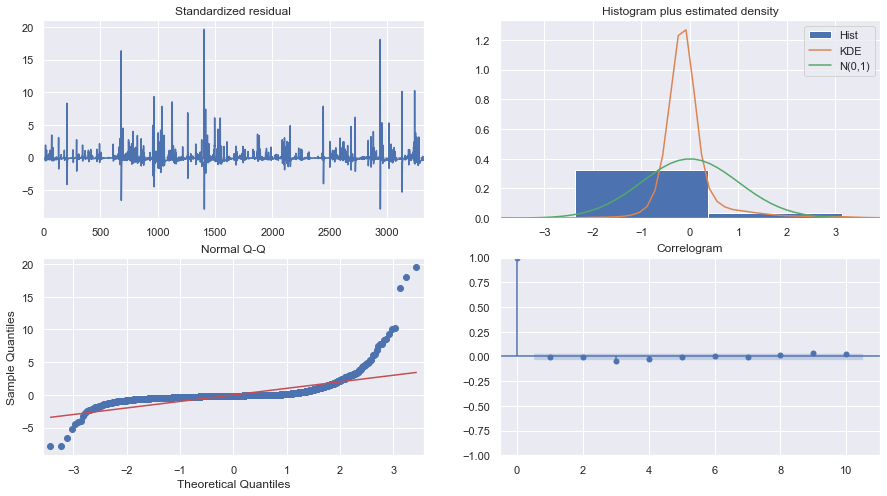

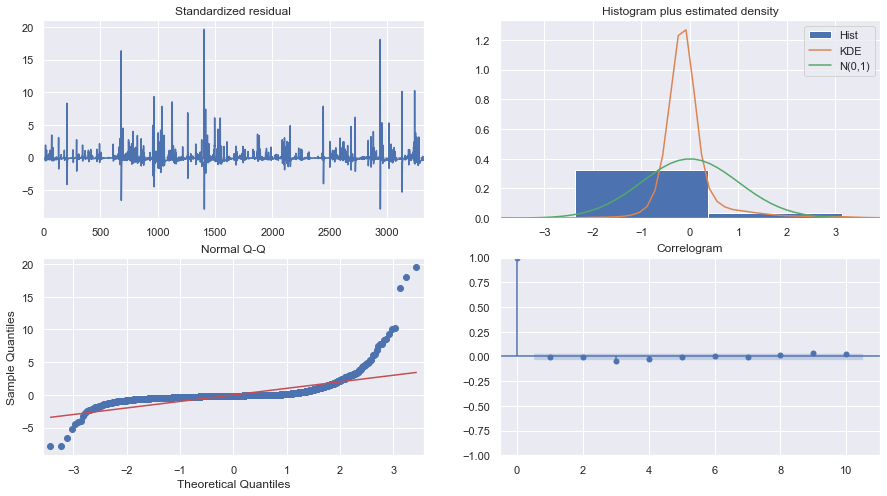

In [32]:
auto.plot_diagnostics()

In [33]:
auto.get_params()['order']

(3, 1, 1)

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create a SARIMAX model from statsmodel library
model = SARIMAX(sample_train, order=auto.get_params()['order'])

In [35]:
# Fit the model
results = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85002D+00    |proj g|=  9.39932D-03


 This problem is unconstrained.



At iterate    5    f=  5.84656D+00    |proj g|=  7.55292D-02

At iterate   10    f=  5.83831D+00    |proj g|=  1.41943D-02

At iterate   15    f=  5.83743D+00    |proj g|=  3.40612D-04

At iterate   20    f=  5.83733D+00    |proj g|=  1.21706D-02

At iterate   25    f=  5.83687D+00    |proj g|=  2.40692D-03

At iterate   30    f=  5.83685D+00    |proj g|=  2.06878D-03

At iterate   35    f=  5.83682D+00    |proj g|=  1.42099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     46      1     0     0   9.692D-06   5.837D+00
  F =   5.8368173978642188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

Check if we obtains the same model of the auto_arima:

In [36]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:              discharge   No. Observations:                 3320
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -19378.234
Date:                Mon, 20 Jun 2022   AIC                          38766.468
Time:                        16:01:30   BIC                          38797.005
Sample:                    01-01-2011   HQIC                         38777.395
                         - 02-02-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8768      0.007    118.977      0.000       0.862       0.891
ar.L2         -0.0624      0.011     -5.468      0.000      -0.085      -0.040
ar.L3          0.0549      0.014      3.999      0.0

### Model Validate

In [37]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:, 'lower discharge']
upper_limits = confidence_intervals.loc[:, 'upper discharge']

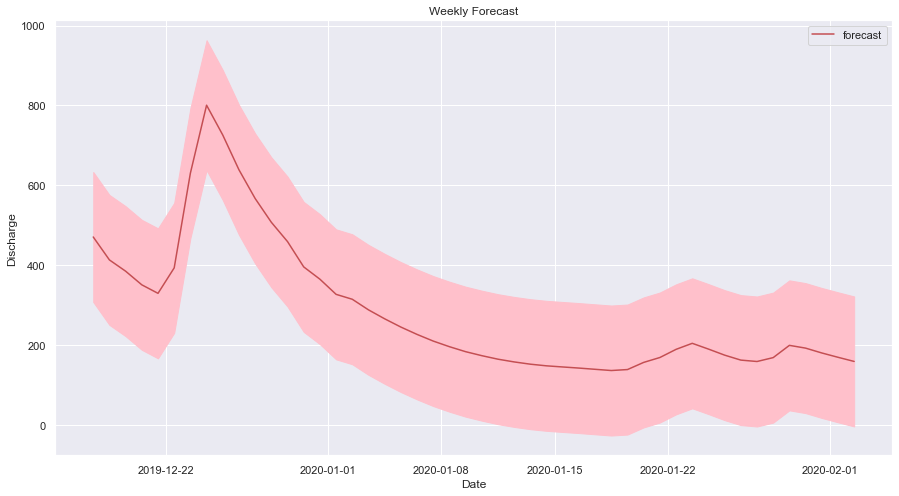

In [38]:
# plot the dranse data

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Weekly Forecast')
plt.legend()
plt.show()

In [39]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-6, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int(alpha=0.32) # 95 percent confidence interval

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower discharge']
upper_limits = confidence_intervals.loc[:,'upper discharge']

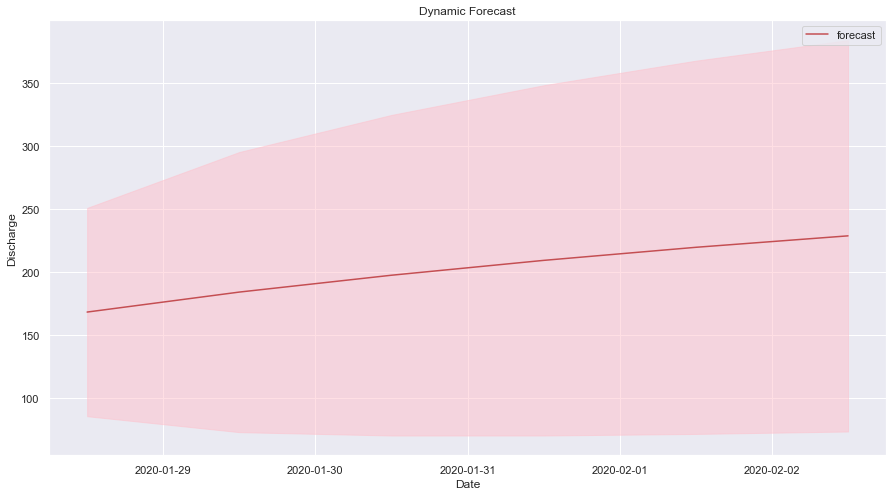

In [40]:
# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
               upper_limits, color='pink', alpha=0.5)

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Dynamic Forecast')
plt.legend()

Text(0.5, 0, 'Time')

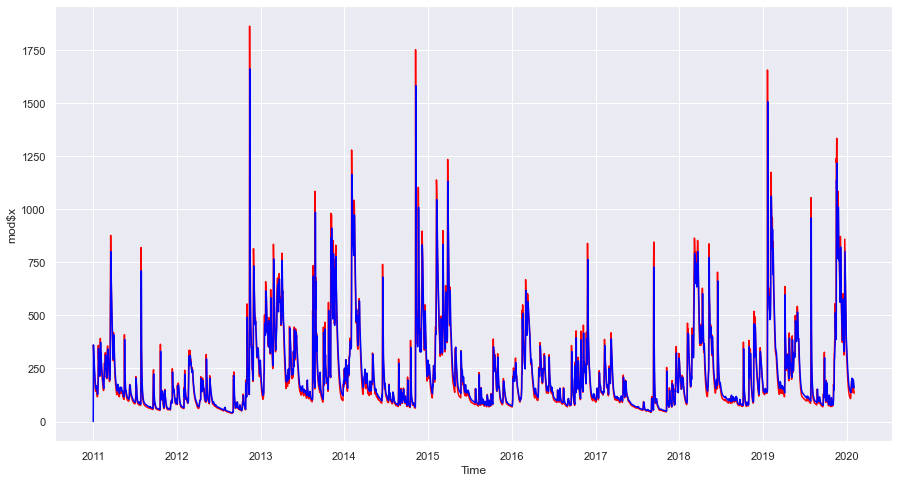

In [41]:
plt.plot(sample_train.discharge, c='red')
plt.plot(results.fittedvalues, c='blue')
plt.ylabel("mod$x")
plt.xlabel("Time")

### Model Evaluation

In [74]:
def forecast_to_df(model, steps=12):
    forecast = model.get_forecast(steps=steps)
    pred_df = forecast.conf_int()
    pred_df['pred'] = forecast.predicted_mean
    pred_df.columns = ['lower', 'upper', 'pred']
    return pred_df

steps = len(sample_test)
pred_df = forecast_to_df(results, steps=steps)
pred_df.head()

,lower,upper,pred
2020-02-03 12:00:00,-11.826458,313.751679,150.962610
2020-02-04 12:00:00,-51.321343,386.514436,167.596546
2020-02-05 12:00:00,-69.994296,431.067337,180.536520
2020-02-06 12:00:00,-81.829352,465.614520,191.892584
2020-02-07 12:00:00,-89.721466,493.633952,201.956243


(<Figure size 864x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Model Validation'}>)

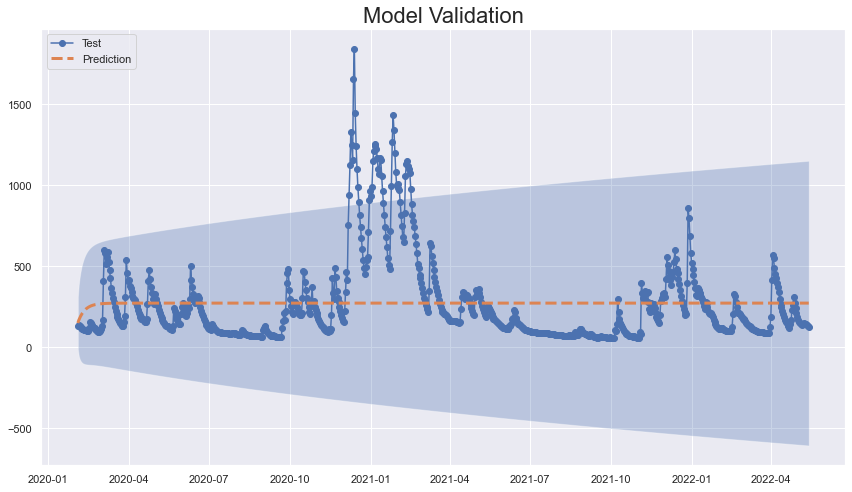

In [76]:
# Plotting Predictions
def plot_train_test_pred(test,pred_df):
    fig,ax = plt.subplots(figsize=(12,7))
    kws = dict(marker='o')
    
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['pred'],label='Prediction',ls='--',linewidth=3)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'],alpha=0.3)
    ax.set_title('Model Validation', fontsize=22)
    ax.legend(loc='upper left')
    fig.tight_layout()
    return fig,ax

plot_train_test_pred(sample_test,pred_df)

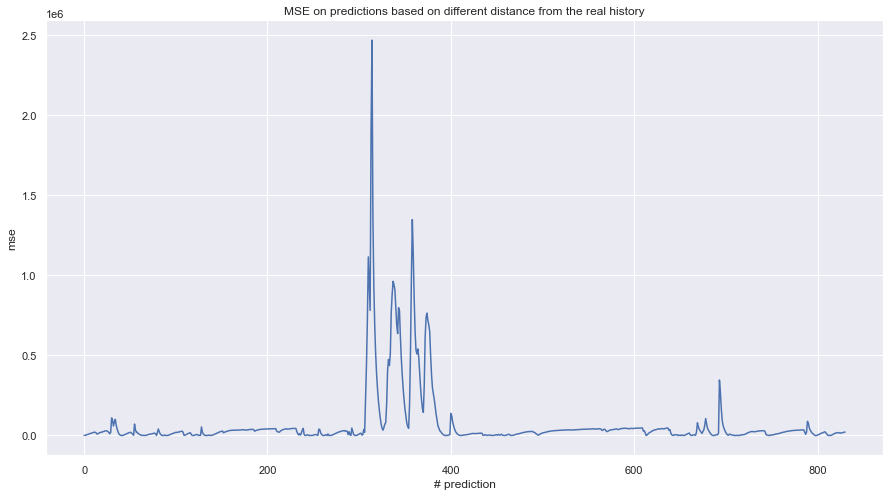

In [77]:
import math
from sklearn.metrics import mean_squared_error
mse = []
preds = pred_df.pred
for i in range(steps):
    mse.append((mean_squared_error([preds[i]],[sample_test['discharge'][i]])))


mse = np.asarray(mse)
index = np.asarray([i for i in range(steps)])
plt.plot(index, mse)
plt.title('MSE on predictions based on different distance from the real history')
plt.xlabel('# prediction')
plt.ylabel('mse')
plt.show()

Generally, forecasting techniques have some problems for long-term predictions. We can see from the previous plot how the MSE varies over time, and the impact of instant discharge variations is not caught. This aspect is influenced by the randomness distribution given by the analysis of discharges during the ACF and PACF analysis. So, we can estimate that ARIMA usage is not a good approach for our final application.

## ANN and LSTM

### Splitting Test and Train for LSTM

In [15]:
sample_train  = train['Tevere ']['mounth']
sample_test = test['Tevere ']['mounth']

# clean and format training data 
sample_train.discharge = sample_train.discharge.astype(float)
sample_train.prec = sample_train.prec.astype(float)
sample_train.temp = sample_train.temp.astype(float)
sample_train = sample_train.drop(columns=['time'])

# clean and format testing data
sample_test.discharge = sample_test.discharge.astype(float)
sample_test.prec = sample_test.prec.astype(float)
sample_test.temp = sample_test.temp.astype(float)
sample_test = sample_test.drop(columns=['time'])
sample_train.tail()

,discharge,temp,prec
2521398,145.627930,8.610651,2.309112e-10
2521399,139.353520,9.400873,2.650724e-12
2521400,130.665040,8.396082,9.117005e-13
2521401,119.768555,7.348291,3.611122e-14
2521402,132.175780,7.709558,9.245022e-15


In [16]:
sample_train.head()

,discharge,temp,prec
2521055,360.40430,13.433801,8.373320e-06
2521056,326.18262,13.917352,7.232591e-05
2521057,298.91602,12.954095,1.324906e-05
2521058,273.66602,14.221063,1.107795e-07
2521059,248.28418,12.358911,3.284007e-05


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [18]:
np.random.seed(7)

In [19]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(sample_train)
scaled_test = scaler.fit_transform(sample_test)

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
# frame as supervised learning
reframed_train = series_to_supervised(scaled_train, 1, 1)
reframed_test = series_to_supervised(scaled_test, 1, 1)

In [22]:
reframed_train.drop(reframed_train.columns[[4, 5]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[4, 5]], axis=1, inplace=True)

In [23]:
print(reframed_train.head(), '\n---------------------------------------------\n', reframed_test.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.176575   0.445207   0.007006  0.157803
2   0.157803   0.460727   0.060515  0.142847
3   0.142847   0.429809   0.011085  0.128996
4   0.128996   0.470476   0.000093  0.115073
5   0.115073   0.410705   0.027477  0.104182 
---------------------------------------------
    var1(t-1)  var2(t-1)     var3(t-1)   var1(t)
1   0.082825   0.275831  4.739330e-07  0.086732
2   0.086732   0.274031  7.989973e-07  0.132328
3   0.132328   0.228227  7.475525e-04  0.154564
4   0.154564   0.379012  4.021070e-03  0.162929
5   0.162929   0.421302  3.207199e-03  0.153549


In [24]:
values_train = reframed_train.values
values_test = reframed_test.values
# split into input and outputs
train_X, train_y = values_train[:, :-1], values_train[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]

In [25]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2904, 1, 3) (2904,) (1245, 1, 3) (1245,)


Epoch 1/50
41/41 - 3s - loss: 0.0689 - val_loss: 0.0831 - 3s/epoch - 65ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0483 - val_loss: 0.0479 - 139ms/epoch - 3ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0366 - val_loss: 0.0323 - 140ms/epoch - 3ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0287 - val_loss: 0.0223 - 137ms/epoch - 3ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0233 - val_loss: 0.0204 - 138ms/epoch - 3ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0202 - val_loss: 0.0197 - 141ms/epoch - 3ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0210 - val_loss: 0.0183 - 153ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0201 - val_loss: 0.0177 - 137ms/epoch - 3ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0198 - val_loss: 0.0188 - 135ms/epoch - 3ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0197 - val_loss: 0.0180 - 137ms/epoch - 3ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0192 - val_loss: 0.0190 - 138ms/epoch - 3ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0192 - val_loss: 0.0196 - 135ms/epoch - 3ms/step
Epoch 13/50
41/41 - 0s - lo

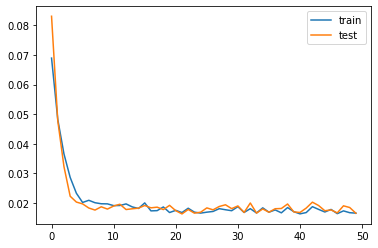

In [26]:
# design network
model = Sequential()
model.add(LSTM(27, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(108))
model.add(Dropout(0.5))
model.add(Dense(12))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
import math
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

39/39 [==============================] - 1s 1ms/step
Test RMSE: 85.931


### Monthly prediction modelling

In [1]:
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json 
import datetime as dt
import warnings
import math
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras import metrics
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='root_mean_squared_error', patience=30, mode='min')

In [4]:
#Load dataset
df = pd.read_pickle('../../monthly/grouped_all.pkl')

In [5]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points_new_fill.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])


In [6]:
datasource = json.load(open('../samples/source_mounth.json', 'r'))
sources_rivers = []
names = []
mounths_rivers = []
italy_sources_mounths = pd.DataFrame()
for key in datasource.keys():
    sources_rivers.append(datasource[key]['source'])
    mounths_rivers.append(datasource[key]['mounth'])
    names.append(key)

italy_sources_mounths['names'] = names
italy_sources_mounths['mounth'] = mounths_rivers
italy_sources_mounths['source'] = sources_rivers
italy_sources_mounths['number_value'] = [i for i in range(0, len(italy_sources_mounths))]
italy_sources_mounths.head()

,names,mounth,source,number_value
0,Tanaro,"[44.950962, 8.690675]","[44.12503, 7.8367176]",0
1,Po,"[44.974716, 12.487255]","[44.841927, 7.6197023]",1
2,Tevere,"[41.730213, 12.233403]","[42.679653, 12.207837]",2
3,Arno,"[43.69623, 10.266045]","[43.864105, 11.632074]",3
4,Reno,"[44.61863, 12.282794]","[44.410408, 11.271765]",4


In [7]:
#dictionaries with the dataframe for each river
sources = {}
mounths = {}
names = list(italy_sources_mounths.names)
for i in range(len(italy_sources_mounths)):
    name = names[i]
    sources[name] = df[df['coords'] == tuple(italy_sources_mounths['source'][i])]
    mounths[name] = df[df['coords'] == tuple(italy_sources_mounths['mounth'][i])]

In [8]:
for name in sources:
    sources[name] = sources[name].set_index('time')
    mounths[name] = mounths[name].set_index('time')

In [9]:
#conversion from a single column dataframe to two arrays, one with the observations and one with the label to predict
def df_to_supervised_discharge(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [10]:
#conversion from a single column dataframe to two arrays, one with the observations and one with the label to predict
def df_to_supervised_temperature(df, window_size=12):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [11]:
#add column with seconds to do the sin cos trick
for name in sources:
    sources[name]['secs'] = sources[name].index.map(pd.Timestamp.timestamp)
    mounths[name]['secs'] = mounths[name].index.map(pd.Timestamp.timestamp)

In [12]:

day = 60*60*24
year = 365.2425*day
for name in sources:
    sources[name]['year_sin'] = np.sin(sources[name]['secs']*(2*np.pi/year))
    mounths[name]['year_sin'] = np.sin(mounths[name]['secs']*(2*np.pi/year))

    sources[name]['year_cos'] = np.cos(sources[name]['secs']*(2*np.pi/year))
    mounths[name]['year_cos'] = np.cos(mounths[name]['secs']*(2*np.pi/year))

    sources[name] = sources[name].drop(columns=['secs'])
    mounths[name] = mounths[name].drop(columns=['secs'])

In [13]:
sources['Tevere '].drop(columns=['prec', 'discharge'])

,coords,temp,year_sin,year_cos
time,,,,
2011-01-15,"(42.679653, 12.207837)",8.797117,0.239478,0.970902
2011-02-15,"(42.679653, 12.207837)",5.777048,0.699798,0.714341
2011-03-15,"(42.679653, 12.207837)",6.310610,0.951104,0.308870
2011-04-15,"(42.679653, 12.207837)",12.820533,0.976054,-0.217529
2011-05-15,"(42.679653, 12.207837)",15.912722,0.741586,-0.670858
...,...,...,...,...
2022-01-15,"(42.679653, 12.207837)",9.267187,0.245027,0.969516
2022-02-15,"(42.679653, 12.207837)",10.023776,0.703872,0.710327
2022-03-15,"(42.679653, 12.207837)",10.524881,0.952855,0.303424


1/1 [==============================] - 1s 525ms/step
Test on sources for Tanaro
MSE: 3.494
MAE: 1.556


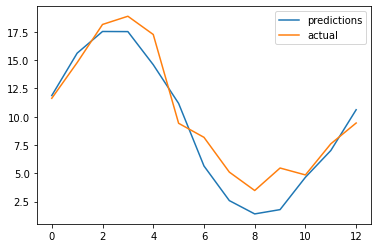

1/1 [==============================] - 0s 373ms/step
Test on sources for Po
MSE: 2.843
MAE: 1.325


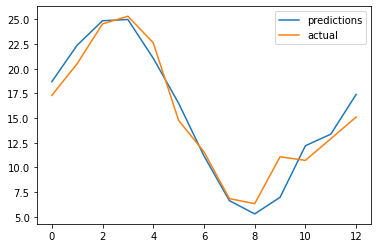

1/1 [==============================] - 0s 403ms/step
Test on sources for Tevere 
MSE: 2.098
MAE: 1.260


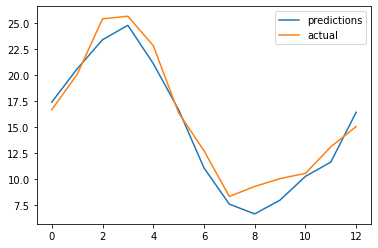

1/1 [==============================] - 0s 486ms/step
Test on sources for Arno
MSE: 2.905
MAE: 1.489


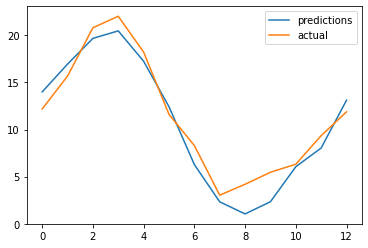

1/1 [==============================] - 0s 394ms/step
Test on sources for Reno
MSE: 5.284
MAE: 2.012


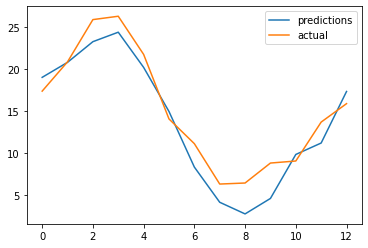

1/1 [==============================] - 0s 392ms/step
Test on sources for Ticino
MSE: 2.079
MAE: 1.108


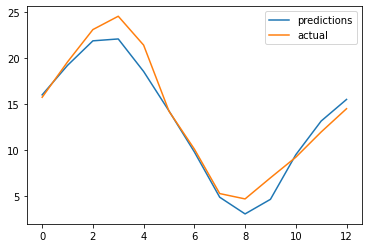

1/1 [==============================] - 0s 414ms/step
Test on sources for Adda
MSE: 2.733
MAE: 1.388


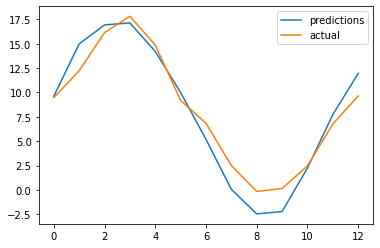

1/1 [==============================] - 0s 423ms/step
Test on sources for Oglio
MSE: 5.433
MAE: 2.038


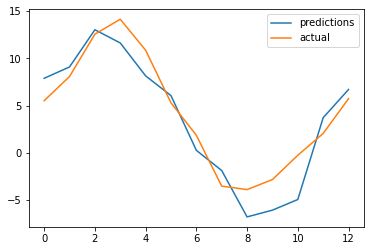

1/1 [==============================] - 0s 380ms/step
Test on sources for Adige
MSE: 5.829
MAE: 1.981


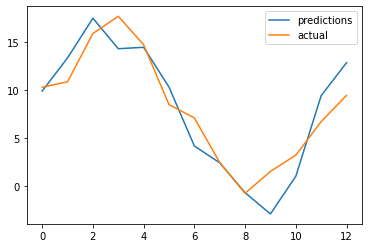

1/1 [==============================] - 0s 393ms/step
Test on sources for Piave
MSE: 10.211
MAE: 2.630


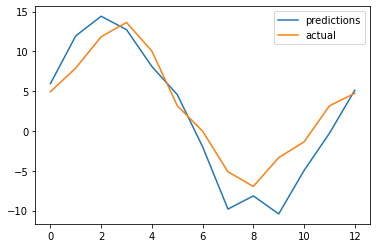

In [16]:
for name in sources:
    src = sources[name].drop(columns=['prec', 'discharge', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_temperature(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]

    model_tmp_src = Sequential()
    model_tmp_src.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_tmp_src.add(Dense(12))
    model_tmp_src.add(Dense(1))

    #model2.summary()
    model_tmp_src.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_tmp_src.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=0, callbacks=[stop])

    test_predictions = model_tmp_src.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Preds': test_predictions, 'Actuals':y_test})
    mse = mean_squared_error(test_predictions, y_test)
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on sources for '+name)
    print('MSE: %.3f' % mse)
    print('MAE: %.3f' % mae)
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 414ms/step
Test on mouths for Tanaro
MSE: 2.361
MAE: 1.252


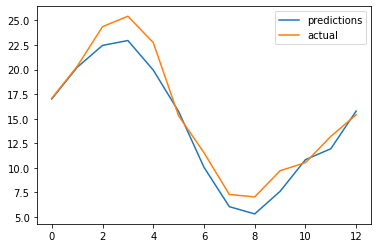

1/1 [==============================] - 0s 396ms/step
Test on mouths for Po
MSE: 4.008
MAE: 1.603


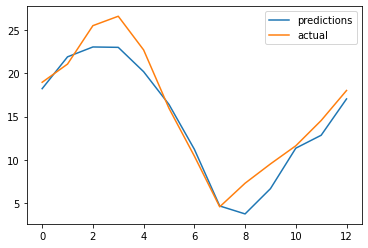

1/1 [==============================] - 0s 390ms/step
Test on mouths for Tevere 
MSE: 6.004
MAE: 2.051


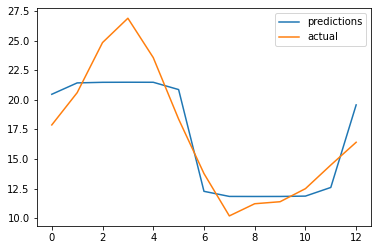

1/1 [==============================] - 0s 457ms/step
Test on mouths for Arno
MSE: 2.557
MAE: 1.270


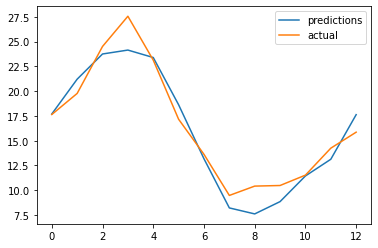

1/1 [==============================] - 0s 435ms/step
Test on mouths for Reno
MSE: 5.046
MAE: 1.817


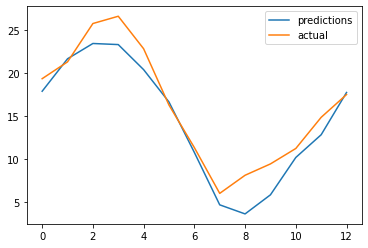

1/1 [==============================] - 0s 377ms/step
Test on mouths for Ticino
MSE: 2.623
MAE: 1.307


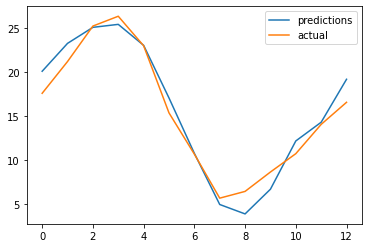

1/1 [==============================] - 1s 1s/step
Test on mouths for Adda
MSE: 2.798
MAE: 1.307


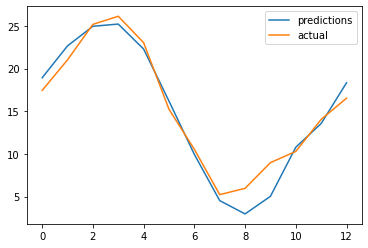

1/1 [==============================] - 0s 455ms/step
Test on mouths for Oglio
MSE: 3.047
MAE: 1.466


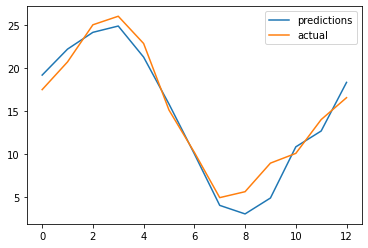

1/1 [==============================] - 0s 403ms/step
Test on mouths for Adige
MSE: 2.435
MAE: 1.168


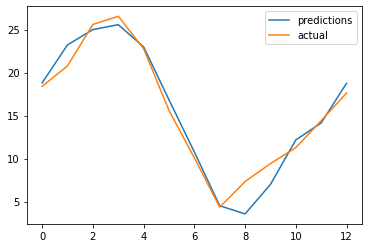

1/1 [==============================] - 0s 384ms/step
Test on mouths for Piave
MSE: 3.277
MAE: 1.420


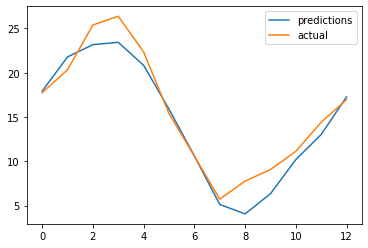

In [18]:
for name in sources:
    src = mounths[name].drop(columns=['prec', 'discharge', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_temperature(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]

    model_tmp_mth = Sequential()
    model_tmp_mth.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_tmp_mth.add(Dense(12))
    model_tmp_mth.add(Dense(1))

    #model2.summary()
    model_tmp_mth.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_tmp_mth.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, verbose=0)
    test_predictions = model_tmp_mth.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Preds': test_predictions, 'Actuals':y_test})
    mse = mean_squared_error(test_predictions, y_test)
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on mouths for '+name)
    print('MSE: %.3f' % mse)
    print('MAE: %.3f' % mae)
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 377ms/step
Test on sources for Tanaro
MSE: 2.347
MAE: 1.246


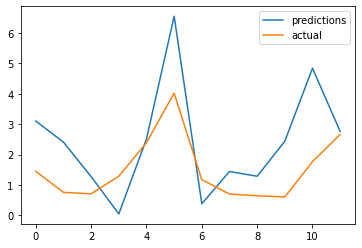

1/1 [==============================] - 0s 397ms/step
Test on sources for Po
MSE: 138.432
MAE: 8.414


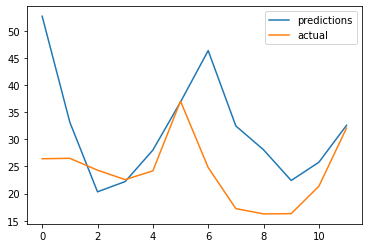

1/1 [==============================] - 0s 394ms/step
Test on sources for Tevere 
MSE: 1277.054
MAE: 29.191


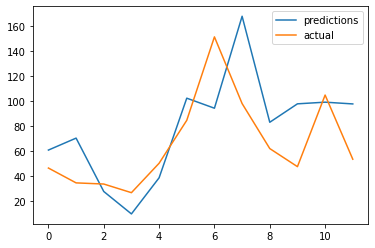

1/1 [==============================] - 0s 439ms/step
Test on sources for Arno
MSE: 0.012
MAE: 0.088


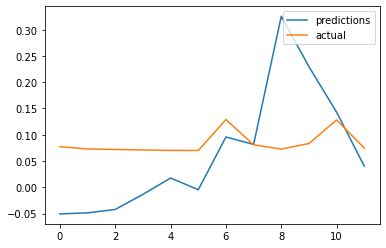

1/1 [==============================] - 0s 377ms/step
Test on sources for Reno
MSE: 115.408
MAE: 8.530


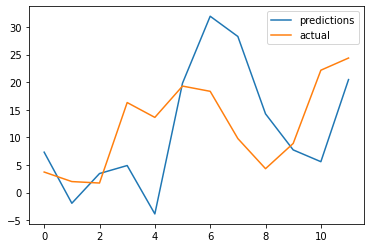

1/1 [==============================] - 0s 377ms/step
Test on sources for Ticino
MSE: 32166.938
MAE: 134.734


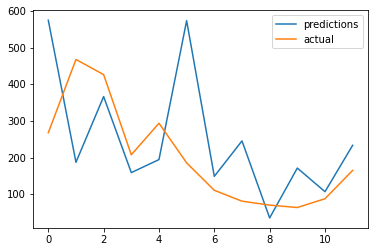

1/1 [==============================] - 0s 375ms/step
Test on sources for Adda
MSE: 22.052
MAE: 4.275


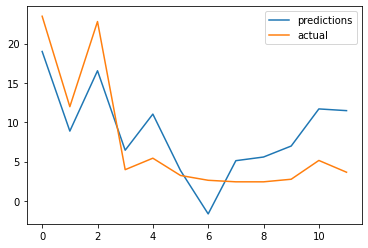

1/1 [==============================] - 0s 372ms/step
Test on sources for Oglio
MSE: 0.680
MAE: 0.543


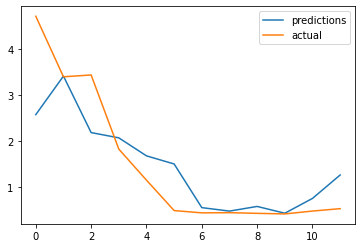

1/1 [==============================] - 0s 380ms/step
Test on sources for Adige
MSE: 111.947
MAE: 8.958


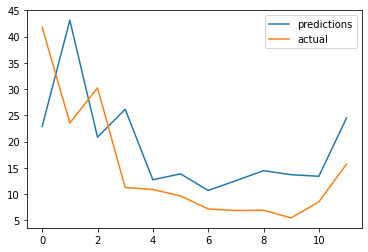

1/1 [==============================] - 0s 377ms/step
Test on sources for Piave
MSE: 0.219
MAE: 0.350


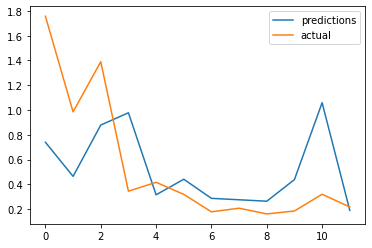

In [60]:
for name in sources:
    src = sources[name].drop(columns=['prec', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_discharge(src, 24)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]
    #normalizing
    X_mean = X_train.mean()
    X_std = X_train.std()
    X_train_sc = (X_train - X_mean) / X_std
    X_val_sc = (X_val - X_mean) / X_std
    X_test_sc = (X_test - X_mean) / X_std


    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_sc = (y_train - X_mean) / X_std
    y_val_sc = (y_val - X_mean) / X_std
    y_test_sc = (y_test - X_mean) / X_std
    
    model_dis_src = Sequential()
    model_dis_src.add(LSTM(32, input_shape=(X_train_sc.shape[1], X_train_sc.shape[2])))
    model_dis_src.add(Dense(12))
    model_dis_src.add(Dense(1))

    #model2.summary()
    model_dis_src.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_dis_src.fit(X_train_sc, y_train_sc, validation_data=(X_val_sc, y_val_sc), epochs=40000, verbose=0, callbacks=[stop])

    test_predictions = model_dis_src.predict(X_test_sc).flatten()
    test_predictions = (test_predictions*X_std)+X_mean
    mse = mean_squared_error(test_predictions, y_test)
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on sources for '+name)
    print('MSE: %.3f' % mse)
    print('MAE: %.3f' % mae)
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()

1/1 [==============================] - 0s 374ms/step
Test on mouths for Tanaro
MSE: 3691.615
MAE: 38.356


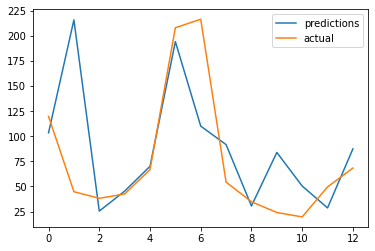

1/1 [==============================] - 0s 379ms/step
Test on mouths for Po
MSE: 106333.670
MAE: 250.267


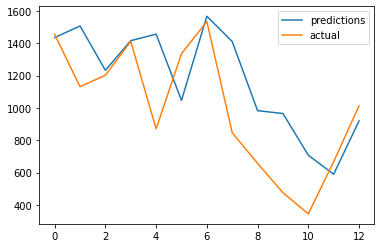

1/1 [==============================] - 0s 374ms/step
Test on mouths for Tevere 
MSE: 29893.105
MAE: 132.618


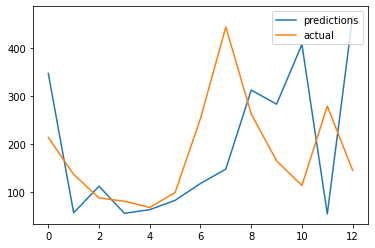

1/1 [==============================] - 0s 372ms/step
Test on mouths for Arno
MSE: 1547.117
MAE: 31.900


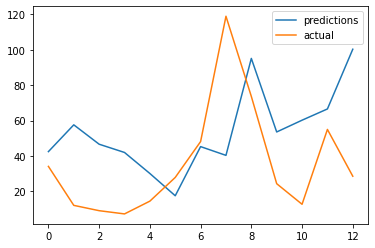

1/1 [==============================] - 0s 418ms/step
Test on mouths for Reno
MSE: 0.184
MAE: 0.391


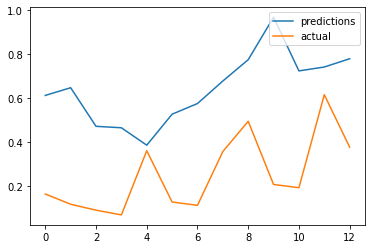

1/1 [==============================] - 0s 410ms/step
Test on mouths for Ticino
MSE: 31421.186
MAE: 133.437


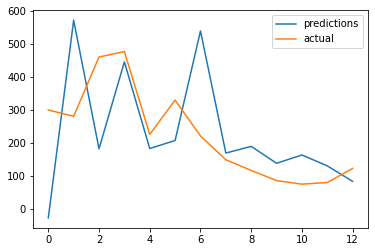

1/1 [==============================] - 0s 390ms/step
Test on mouths for Adda
MSE: 18968.879
MAE: 108.044


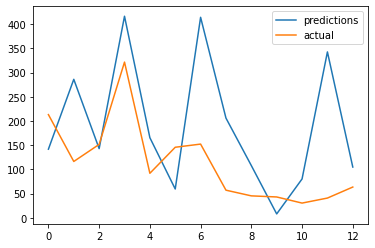

1/1 [==============================] - 0s 403ms/step
Test on mouths for Oglio
MSE: 1571.353
MAE: 28.508


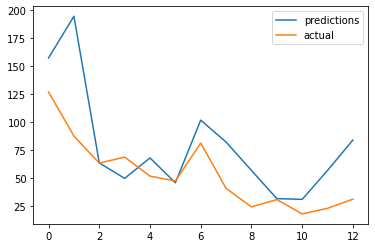

1/1 [==============================] - 0s 415ms/step
Test on mouths for Adige
MSE: 12058.702
MAE: 95.674


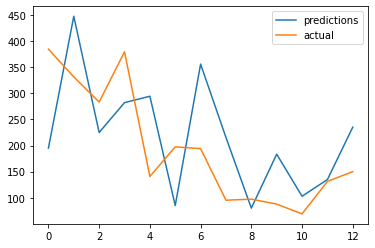

1/1 [==============================] - 0s 368ms/step
Test on mouths for Piave
MSE: 4318.250
MAE: 46.373


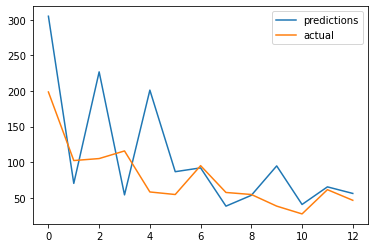

In [58]:
for name in mounths:
    src = mounths[name].drop(columns=['prec', 'coords'])
    #creating the x tensor and the labels
    X, y = df_to_supervised_discharge(src)

    #splitting
    n = len(X)
    X_train, y_train = X[0:int(n*0.7)], y[0:int(n*0.7)]
    X_val, y_val = X[int(n*0.7):int(n*0.9)], y[int(n*0.7):int(n*0.9)]
    X_test, y_test = X[int(n*0.9):], y[int(n*0.9):]
    #normalizing
    X_mean = X_train.mean()
    X_std = X_train.std()
    X_train_sc = (X_train - X_mean) / X_std
    X_val_sc = (X_val - X_mean) / X_std
    X_test_sc = (X_test - X_mean) / X_std


    y_mean = y_train.mean()
    y_std = y_train.std()
    y_train_sc = (y_train - X_mean) / X_std
    y_val_sc = (y_val - X_mean) / X_std
    y_test_sc = (y_test - X_mean) / X_std
    
    model_dis_mth = Sequential()
    model_dis_mth.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model_dis_mth.add(Dense(12))
    model_dis_mth.add(Dense(1))

    #model2.summary()
    model_dis_mth.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])
    model_dis_mth.fit(X_train_sc, y_train_sc, validation_data=(X_val_sc, y_val_sc), epochs=40000, verbose=0, callbacks=[stop])

    test_predictions = model_dis_mth.predict(X_test_sc).flatten()
    test_predictions = (test_predictions*X_std)+X_mean
    mse = mean_squared_error(test_predictions, y_test)
    mae = mean_absolute_error(test_predictions, y_test)
    print('Test on mouths for '+name)
    print('MSE: %.3f' % mse)
    print('MAE: %.3f' % mae)
    plt.plot(test_predictions, label='predictions')
    plt.plot(y_test, label='actual')
    plt.legend(loc="upper right")
    plt.show()